In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import join as p_join

import seaborn as sns

from tqdm import tqdm


##################################
## GLOBAL SETTINGS ###############
##################################
plt.rcParams["figure.figsize"] = (12,8)

def seed_all(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    print("[ Using Seed : ", seed, " ]")

####################################
#####   SEED ALL EXPERIMENTS   #####
####################################
seed_all()

[ Using Seed :  42  ]


In [2]:
FOLDERS = [item for item in os.listdir(p_join('..', 'data_2')) if 'L=6.6' in item]
FOLDERS

['N2=27_L=6.6_input=2',
 'N2=21_L=6.6_input=-4',
 'N2=21_L=6.6_input=-2',
 'N2=27_L=6.6_input=-2',
 'N2=25_L=6.6_input=4',
 'N2=21_L=6.6_input=2',
 'N2=23_L=6.6_input=-4',
 'N2=27_L=6.6_input=-4',
 'N2=23_L=6.6_input=4',
 'N2=25_L=6.6_input=-2',
 'N2=21_L=6.6_input=4',
 'N2=25_L=6.6_input=-4',
 'N2=23_L=6.6_input=2',
 'N2=23_L=6.6_input=-2',
 'N2=27_L=6.6_input=4',
 'N2=25_L=6.6_input=2']

In [3]:
def normalize_data(X):
    mean = X.mean(0)
    std = X.std(0)
    return (X - mean) / std

In [4]:
def select_n_center_features(data: np.ndarray, n_features: int, verbose: bool = False) -> np.ndarray:
    from copy import deepcopy

    total_components = data.shape[1]
    start = int((total_components - n_features)/2)
    res = deepcopy(data)[:, start: start + n_features]
    if verbose:
        print(f'Selected features from indexes:  [{start}, {start + n_features})')
    return res

In [5]:
def map_classes(i, j):
    if i == 0 and j == 0:
        return 0
    elif i == 0 and j == 1:
        return 1
    elif i == 1 and j == 0:
        return 2
    elif i == 1 and j == 1:
        return 3

In [6]:
def create_dataset(folders, verbose=False, feature_nums=16):
    X_merged, Y_merged = [], []
    for folder_path in tqdm(folders):
        X_path = p_join('..', 'data_2', folder_path, '2nd_exp_Input.txt')
        Y_path_down = p_join('..', 'data_2', folder_path, '2nd_exp_Topology_down.txt')
        Y_path_up = p_join('..', 'data_2', folder_path, '2nd_exp_Topology_up.txt')
        params_path = p_join('..', 'data_2', folder_path, '2nd_exp_Parameters.txt')

        X = select_n_center_features(pd.read_csv(X_path).values, feature_nums)
        Y_down = pd.read_csv(Y_path_down).values
        Y_up = pd.read_csv(Y_path_up).values
        Y = np.array([map_classes(Y_up[i], Y_down[i]) for i in range(Y_up.shape[0])])

        X_merged.append(X)
        Y_merged.append(Y)

    # Merge and shuffle it!
    X, Y = np.concatenate(X_merged, axis=0), np.concatenate(Y_merged, axis=0)
    indexes_for_shuffle = np.random.permutation(np.arange(X.shape[0]))
    X = X[indexes_for_shuffle]
    Y = Y[indexes_for_shuffle]
    if verbose:
        print('Dataset cteated!')
    return X, Y

In [7]:
###############################
##### IMPORT ML METHODS   #####
###############################
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


#################################
####### GLOBAL CONFIG ###########
#################################
CONFIG = {'scoring': 'accuracy',
          'cv': 5,
          'n_jobs': -1}

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from copy import deepcopy

def calc_ml_method(model, config, X, Y):
    res = {}

    scoring = config.get('scoring', 'accuracy')
    cv = config.get('cv', 5)
    n_jobs = config.get('n_jobs', 4)
    
    scores = cross_val_score(model, X, Y, cv=cv, scoring=scoring, n_jobs=n_jobs)
    res[str(scoring)] = scores
        
    return res

def greed_searc_cv(model_class, params, config, X, Y):
    res = {}

    scoring = config.get('scoring', 'accuracy')
    cv = config.get('cv', 5)
    n_jobs = config.get('n_jobs', 4)
    
    model = GridSearchCV(model_class,
                         params,
                         scoring=scoring,
                         cv=cv,
                         n_jobs=n_jobs)
    model.fit(X, Y)
    res[f'best_{str(scoring)}_score'] = model.best_score_
    res['best_params'] = model.best_params_
    res['cv_results'] = model.cv_results_
    
    return res    

### Try PCA:

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 12.63it/s]


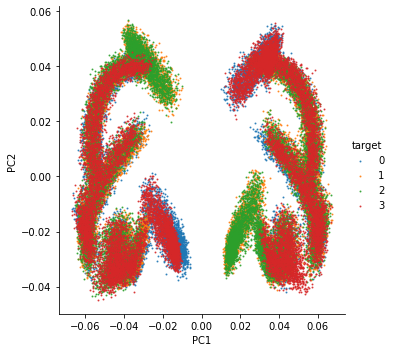

In [9]:
from sklearn import decomposition

X, Y = create_dataset(FOLDERS)

pca = decomposition.PCA(n_components=2)
pc = pca.fit_transform(X)

pc_df = pd.DataFrame(data=pc, columns = ['PC1', 'PC2'])
pc_df['target'] = Y


sns.lmplot(x="PC1", y="PC2",
           data=pc_df, 
           fit_reg=False, 
           hue='target', # color by target
           legend=True,
           scatter_kws={"s": 1}) # specify the point size
pass

In [29]:
print(pca.explained_variance_ratio_)

[0.36706239 0.1496527 ]


/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to conv

### Try TSNE:

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 15.57it/s]
/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 63984 samples in 0.001s...
[t-SNE] Computed neighbors for 63984 samples in 97.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 63984
[t-SNE] Computed conditional probabilities for sample 2000 / 63984
[t-SNE] Computed conditional probabilities for sample 3000 / 63984
[t-SNE] Computed conditional probabilities for sample 4000 / 63984
[t-SNE] Computed conditional probabilities for sample 5000 / 63984
[t-SNE] Computed conditional probabilities for sample 6000 / 63984
[t-SNE] Computed conditional probabilities for sample 7000 / 63984
[t-SNE] Computed conditional probabilities for sample 8000 / 63984
[t-SNE] Computed conditional probabilities for sample 9000 / 63984
[t-SNE] Computed conditional probabilities for sample 10000 / 63984
[t-SNE] Computed conditional probabilities for sample 11000 / 63984
[t-SNE] Computed conditional probabilities for sample 12000 / 63984
[t-SNE] Computed conditional probabilities for sa

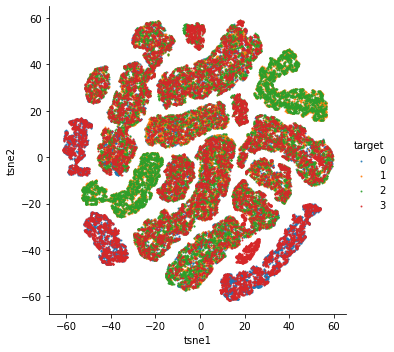

In [10]:
from sklearn.manifold import TSNE

X, Y = create_dataset(FOLDERS)

tsne = TSNE(n_components=2, verbose=1, random_state=42)
tsne_components = tsne.fit_transform(X)

tsne_df = pd.DataFrame(data=tsne_components, columns = ['tsne1', 'tsne2'])
tsne_df['target'] = Y

sns.lmplot(x="tsne1", y="tsne2",
           data=tsne_df, 
           fit_reg=False, 
           hue='target', # color by target
           legend=True,
           scatter_kws={"s": 1}) # specify the point size
pass

### Test `KNeighborsClassifier`

In [11]:
for i in range(1, len(FOLDERS)):
    folders = FOLDERS[: i]
    X, Y = create_dataset(folders)
    X = normalize_data(X)
    for f in folders:
        print(f)
    print()
    res = calc_ml_method(KNeighborsClassifier(), CONFIG, X, Y)
    print(res)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]

N2=27_L=6.6_input=2



{'accuracy': array([0.895     , 0.91875   , 0.89      , 0.9075    , 0.89486859])}


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]

N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4



{'accuracy': array([0.890625  , 0.894375  , 0.895625  , 0.88805503, 0.89868668])}


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 14.30it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2

{'accuracy': array([0.86708333, 0.85583333, 0.84910379, 0.84243435, 0.85452272])}


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.18it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2

{'accuracy': array([0.6746875 , 0.68240075, 0.70084401, 0.68834011, 0.67364802])}


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 15.14it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4

{'accuracy': array([0.69742436, 0.68167042, 0.69967492, 0.69442361, 0.70667667])}


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 16.38it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2

{'accuracy': array([0.60345905, 0.60950198, 0.60075016, 0.61992082, 0.60004168])}


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 16.58it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4

{'accuracy': array([0.6074299 , 0.5965351 , 0.60600107, 0.59503394, 0.60432297])}


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 15.43it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4

{'accuracy': array([0.62884826, 0.61712768, 0.61190997, 0.62519537, 0.61706783])}


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 15.35it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4
N2=23_L=6.6_input=4

{'accuracy': array([0.54688151, 0.5601556 , 0.55348708, 0.56501806, 0.55848847])}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.01it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4
N2=23_L=6.6_input=4
N2=25_L=6.6_input=-2

{'accuracy': array([0.55963991, 0.55251313, 0.55913978, 0.55363841, 0.55976494])}


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 16.35it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4
N2=23_L=6.6_input=4
N2=25_L=6.6_input=-2
N2=21_L=6.6_input=4

{'accuracy': array([0.58376904, 0.58956581, 0.57149352, 0.57410775, 0.57405934])}


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 17.14it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4
N2=23_L=6.6_input=4
N2=25_L=6.6_input=-2
N2=21_L=6.6_input=4
N2=25_L=6.6_input=-4

{'accuracy': array([0.53323609, 0.53323609, 0.54282142, 0.54350318, 0.54298218])}


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 16.33it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4
N2=23_L=6.6_input=4
N2=25_L=6.6_input=-2
N2=21_L=6.6_input=4
N2=25_L=6.6_input=-4
N2=23_L=6.6_input=2

{'accuracy': array([0.54933641, 0.55481823, 0.55237088, 0.54785034, 0.54938925])}


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 16.09it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4
N2=23_L=6.6_input=4
N2=25_L=6.6_input=-2
N2=21_L=6.6_input=4
N2=25_L=6.6_input=-4
N2=23_L=6.6_input=2
N2=23_L=6.6_input=-2

{'accuracy': array([0.5325058 , 0.53166027, 0.52978476, 0.53407163, 0.53237474])}


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.18it/s]


N2=27_L=6.6_input=2
N2=21_L=6.6_input=-4
N2=21_L=6.6_input=-2
N2=27_L=6.6_input=-2
N2=25_L=6.6_input=4
N2=21_L=6.6_input=2
N2=23_L=6.6_input=-4
N2=27_L=6.6_input=-4
N2=23_L=6.6_input=4
N2=25_L=6.6_input=-2
N2=21_L=6.6_input=4
N2=25_L=6.6_input=-4
N2=23_L=6.6_input=2
N2=23_L=6.6_input=-2
N2=27_L=6.6_input=4

{'accuracy': array([0.52779862, 0.5214637 , 0.52879887, 0.5203801 , 0.52413103])}


### Try `KNeighborsClassifier` Grid Search

In [12]:
# greed_searc_cv(KNeighborsClassifier(),
#                {'n_neighbors': [1,3,5,7], 'weights':['uniform', 'distance']},
#                CONFIG,
#                X, Y)

### Plot confusion matrix

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 15.73it/s]


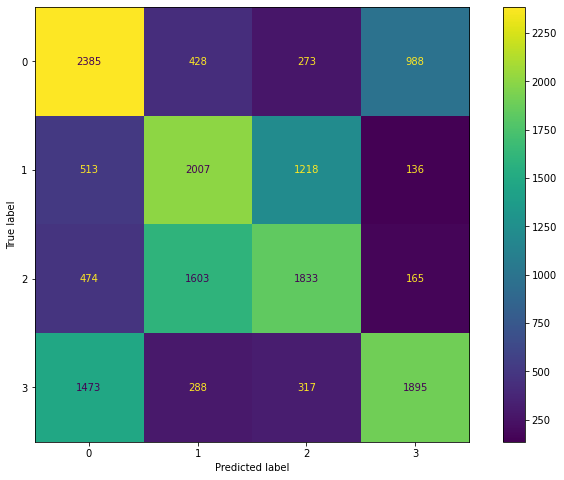

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Plot KNeighborsClassifier
X, y = create_dataset(FOLDERS)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [14]:
# Calc Accuracy:
acc = (predictions == y_test).sum()/len(predictions)
acc

0.5076269067266816

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 15.19it/s]


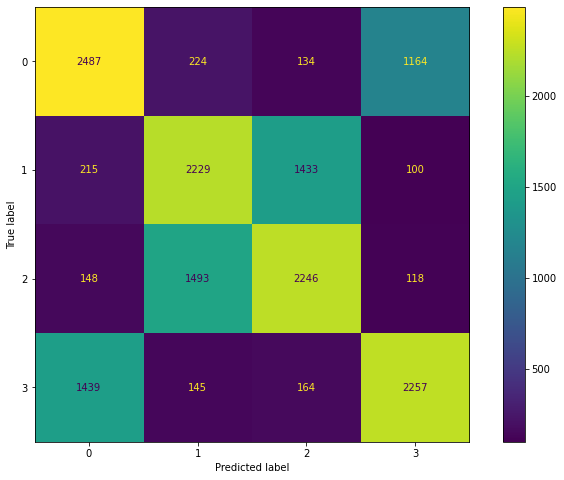

In [15]:
# Plot Random classifier
X, y = create_dataset(FOLDERS)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [16]:
# Calc Accuracy:
acc = (predictions == y_test).sum()/len(predictions)
acc

0.576331582895724

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.25it/s]


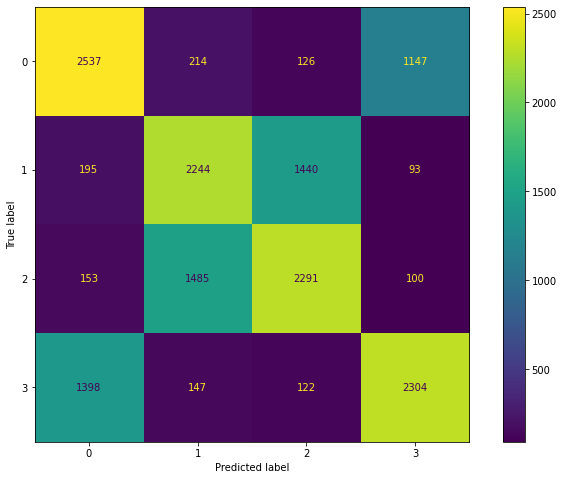

0.5861465366341585

In [36]:
# Plot Random classifier
X, y = create_dataset(FOLDERS)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
clf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=50)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

# Calc Accuracy:
acc = (predictions == y_test).sum()/len(predictions)
acc

### Try other methods

In [17]:
X, Y = create_dataset(FOLDERS)

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 15.89it/s]


In [18]:
### Log regression
accuracies_log_reg = calc_ml_method(LogisticRegression(), CONFIG, X, Y)
accuracies_log_reg

{'accuracy': array([0.32109088, 0.32304446, 0.31593342, 0.31304212, 0.31634886])}

In [19]:
### KNN[5]
accuracies_knn = calc_ml_method(KNeighborsClassifier(n_neighbors=5), CONFIG, X, Y)
accuracies_knn

{'accuracy': array([0.51207314, 0.51473001, 0.50660311, 0.50793155, 0.50656455])}

In [20]:
### MLP
accuracies_mlp = calc_ml_method(MLPClassifier(), CONFIG, X, Y)
accuracies_mlp

{'accuracy': array([0.39603032, 0.3846214 , 0.37774478, 0.38899742, 0.38660519])}

In [21]:
### GaussianNB
accuracies_GNB = calc_ml_method(GaussianNB(), CONFIG, X, Y)
accuracies_GNB

{'accuracy': array([0.32507619, 0.32366961, 0.32241932, 0.31562085, 0.31869334])}

In [22]:
### SVC
accuracies_SVC = calc_ml_method(svm.SVC(), CONFIG, X, Y)
accuracies_SVC

/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to conv

{'accuracy': array([0.49128702, 0.48206611, 0.48495741, 0.48995858, 0.48358862])}

In [23]:
### Lin Classifier
accuracies_lin_reg = calc_ml_method(SGDClassifier(), CONFIG, X, Y)
accuracies_lin_reg

{'accuracy': array([0.3249199 , 0.31319841, 0.32327889, 0.27522075, 0.28008753])}

In [24]:
### RF Classifier
accuracies_rf = calc_ml_method(RandomForestClassifier(random_state=42), CONFIG, X, Y)
accuracies_rf

{'accuracy': array([0.58208955, 0.58443385, 0.58404314, 0.57818239, 0.57728978])}

### Feature importance on entire dataset

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]
/home/akhorkin/Repositories/ml_dl_with_topology_data/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: -6.07566
Feature: 1, Score: 4.30221
Feature: 2, Score: -1.45641
Feature: 3, Score: -3.11768
Feature: 4, Score: 9.11916
Feature: 5, Score: 6.75363
Feature: 6, Score: -1.54544
Feature: 7, Score: 7.64360
Feature: 8, Score: -7.16926
Feature: 9, Score: -0.22778
Feature: 10, Score: -6.25941
Feature: 11, Score: -10.63552
Feature: 12, Score: 1.77460
Feature: 13, Score: -0.75929
Feature: 14, Score: -4.30383
Feature: 15, Score: -4.35189


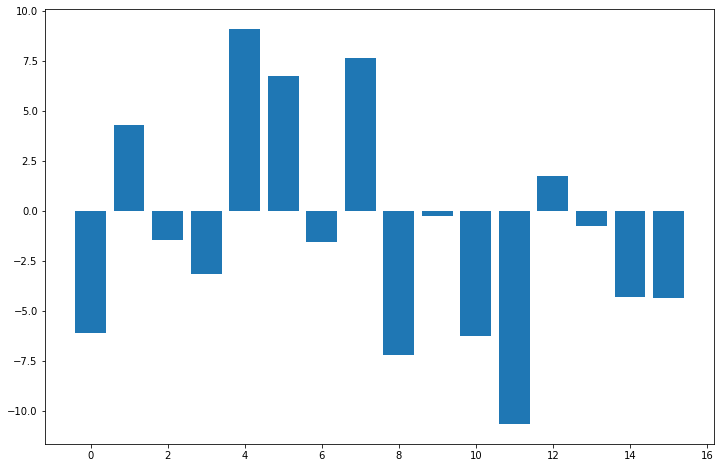

In [25]:
# Train Log Reg on entire dataset to get feature importance
X, Y = create_dataset(FOLDERS)
model = LogisticRegression()
model.fit(X, Y)

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 15.82it/s]


Feature: 0, Score: -0.19878
Feature: 1, Score: 0.17439
Feature: 2, Score: -0.10861
Feature: 3, Score: 0.00280
Feature: 4, Score: 0.08818
Feature: 5, Score: 0.33688
Feature: 6, Score: -0.25851
Feature: 7, Score: 0.42056
Feature: 8, Score: -0.37225
Feature: 9, Score: 0.17313
Feature: 10, Score: -0.24084
Feature: 11, Score: -0.23327
Feature: 12, Score: 0.00386
Feature: 13, Score: 0.01829
Feature: 14, Score: -0.13497
Feature: 15, Score: -0.14337


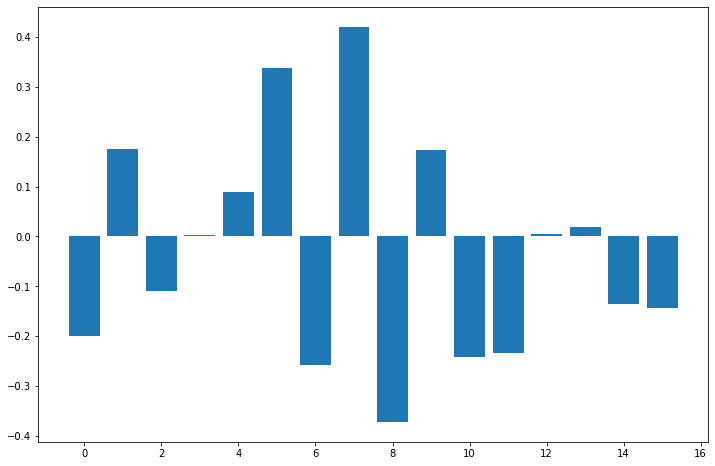

In [26]:
# Train Lin Reg on entire dataset to get feature importance
X, Y = create_dataset(FOLDERS)

model = SGDClassifier()
model.fit(X, Y)

# get importance
importance = model.coef_[0]
# importance.shape
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 15.86it/s]


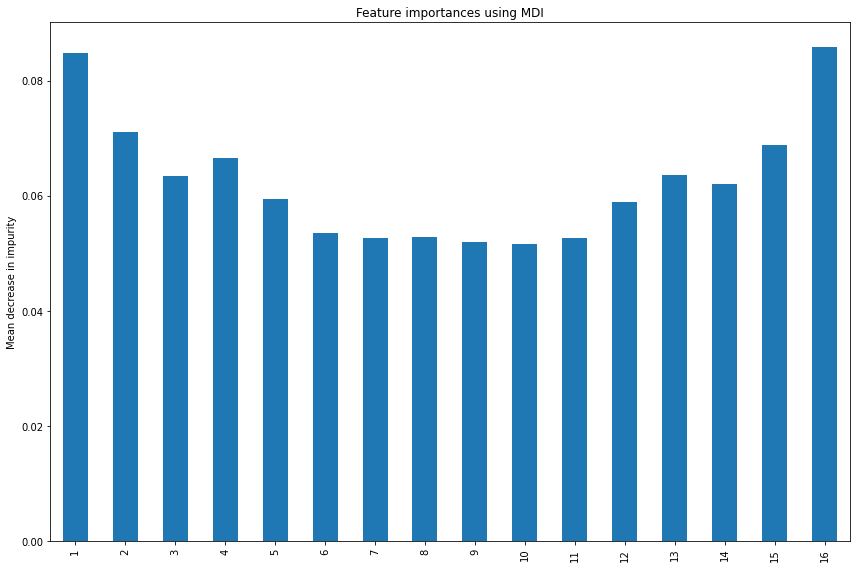

In [27]:
# Train Random Forest on entire dataset to get feature importance
X, Y = create_dataset(FOLDERS)

forest = RandomForestClassifier(random_state=42)
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

feature_names = [str(i + 1) for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)# yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()